Feature Scaling, different padding, cross validation, take part data, different accuracies, more refining of pattern, visual inspection of chunks, increase data size...

--drop less than 5 or 6, moving average, scaling voltage with 48, formula value instead of hardcoding

In [1]:
#from sklearn.preprocessing import StandardScaler

# Seed value
# Apparently we may use different seed values at each stage
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
#from keras import backend as K
#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
#K.set_session(sess)
# for later versions:
# session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
# tf.compat.v1.keras.backend.set_session(sess)

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from os import listdir
import sys
import os

In [3]:
def add_chunk_to_group_single(df):
    df["speed"] = df["speed"].astype(float)
    
    #checking if speed >=25 and making it 0
    #df.loc[df['speed'] >=255, 'speed'] = 0
    #df.loc[df['altitude'] >=4000, 'altitude'] = 0
    
    df["main_bat"] = df["main_bat"].astype(float)
    meanspeed = df["speed"].mean()
    meanspeed = 1
    df["speed"] = df["speed"]/meanspeed
    #df["speed"] = df["speed"].rolling(window=1).mean()
    mean_bat = df["main_bat"].mean()
    mean_bat = 1
    df["main_bat"] = df["main_bat"]/mean_bat
    #df["main_bat"] = df["main_bat"]*2
    df["main_bat"] = df["main_bat"].rolling(window=2).mean()
    df = df.fillna(0)
    inner_list = list()
    inner_list_debug = list()
    start_speed = 10/meanspeed
    start_chunk=1
    start_pad =1
    hang_count_max=3
    hangover_count=hang_count_max
    max_speed = 3/meanspeed
    
    
    for index, row in df.iterrows():
        if(row.speed>=start_speed and start_chunk==1):
            #print("row speed:", row.speed)
            #print("out of loop")
            dummy = 0
        else:
            if(start_chunk==1):
                for i in range(start_pad):
                    if((index-(start_pad-i))>0):
                        inner_list.append(df.iloc[index-(start_pad-i)].drop(["moment_time", "ride_id"]).values)
                        inner_list_debug.append(df.iloc[index-(start_pad-i)].values)
                        #--print("index start pad:", index-(start_pad-i))
                start_chunk = 0
                #--print("Inner List start chunk:", inner_list_debug)
    
            if(row.speed>max_speed):
                #print("row speed: max_speed:", row.speed, max_speed)
                hangover_count=hang_count_max
                max_speed = row.speed
                inner_list.append(df.iloc[index].drop(["moment_time", "ride_id"]).values)
                inner_list_debug.append(df.iloc[index].values)
            else:
                hangover_count = hangover_count-1
                #print("else row speed: max_speed:", row.speed, max_speed)
                if(hangover_count>=0):
                    #print('hang count not expired',df.iloc[index].values)
                    inner_list.append(df.iloc[index].drop(["moment_time", "ride_id"]).values)
                    inner_list_debug.append(df.iloc[index].values)
                else:
                    len_inner_list = len(inner_list)
                    len_inner_list = len_inner_list - (hang_count_max + 1) - start_pad
                    if(len_inner_list>0):
                        #print('append to group after hangover')
                        #print(np.asarray(inner_list))
                        check_array = np.asarray(inner_list)
                        
                        flag_check_speed_breaker = chunk_filter(check_array)
                        
                        if(np.isscalar(flag_check_speed_breaker) != True):
                        
                        
                            max_values = check_array.max(axis=0, keepdims=True)
                            min_values = check_array.min(axis=0, keepdims=True)
                            #print("max_values:", max_values[0][1])
                            #print("min_values:", min_values[0][1])
                            #print("Max - min:", max_values[0][1] - min_values[0][1])
                            
                            
                            if(max_values[0][1]-min_values[0][1]>(9/meanspeed)):
                                #print(check_array)
                                #print(scale_altitude(check_array))
                                #scale_altitude_debug(inner_list_debug)
                                #print(":::")
                                #--print("Inner List:", inner_list_debug)
                                group_single.append(scale_altitude(check_array))
                                group_debug_single.append(np.asarray(scale_altitude_debug(inner_list_debug))) 
                    inner_list.clear()
                    inner_list_debug.clear()
                    start_chunk=1
                    hangover_count=hang_count_max
                    max_speed = 3/meanspeed

In [4]:
def add_chunk_to_group_double(df):
    df["speed"] = df["speed"].astype(float)
    
    #checking if speed >=25 and making it 0
    #df.loc[df['speed'] >=255, 'speed'] = 0
    #df.loc[df['altitude'] >=4000, 'altitude'] = 0
    
    df["main_bat"] = df["main_bat"].astype(float)
    meanspeed = df["speed"].mean()
    meanspeed = 1
    df["speed"] = df["speed"]/meanspeed
    #df["speed"] = df["speed"].rolling(window=1).mean()
    mean_bat = df["main_bat"].mean()
    mean_bat = 1
    df["main_bat"] = df["main_bat"]/mean_bat
    #df["main_bat"] = df["main_bat"]*2
    df["main_bat"] = df["main_bat"].rolling(window=2).mean()
    
    df = df.fillna(0)
    inner_list = list()
    inner_list_debug = list()
    start_speed = 10/meanspeed
    start_chunk=1
    start_pad = 1
    hang_count_max=3
    hangover_count=hang_count_max
    max_speed = 3/meanspeed
    
    for index, row in df.iterrows():
        if(row.speed>=start_speed and start_chunk==1):
            #print("row speed:", row.speed)
            #print("out of loop")
            dummy = 0
            #to discuss
            #continue
        else:
            if(start_chunk==1):
                for i in range(start_pad):
                    if((index-(start_pad-i))>0):
                        inner_list.append(df.iloc[index-(start_pad-i)].drop(["moment_time", "ride_id"]).values)
                        inner_list_debug.append(df.iloc[index-(start_pad-i)].values)
                        #--print("index start pad:", index-(start_pad-i))
                start_chunk = 0
                #--print("Inner List start chunk:", inner_list_debug)

    
            if(row.speed>max_speed):
                #print("row speed: max_speed:", row.speed, max_speed)
                hangover_count=hang_count_max
                max_speed = row.speed
                inner_list.append(df.iloc[index].drop(["moment_time", "ride_id"]).values)
                inner_list_debug.append(df.iloc[index].values)
            else:
                hangover_count = hangover_count-1
                #print("else row speed: max_speed:", row.speed, max_speed)
                if(hangover_count>=0):
                    #print('hang count not expired',df.iloc[index].values)
                    inner_list.append(df.iloc[index].drop(["moment_time", "ride_id"]).values)
                    inner_list_debug.append(df.iloc[index].values)
                else:
                    len_inner_list = len(inner_list)
                    len_inner_list = len_inner_list - (hang_count_max + 1) - start_pad
                    if(len_inner_list>0):
                        #print('append to group after hangover')
                        #print(np.asarray(inner_list))
                        check_array = np.asarray(inner_list)
                        
                        check_array = np.asarray(inner_list)
                        
                        flag_check_speed_breaker = chunk_filter(check_array)
                        
                        if(np.isscalar(flag_check_speed_breaker) != True):
                            
                            max_values = check_array.max(axis=0, keepdims=True)
                            min_values = check_array.min(axis=0, keepdims=True)
                            #print(min_speed)
                            if(max_values[0][1]-min_values[0][1]>(9/meanspeed)):
                                group_double.append(scale_altitude(check_array))
                                group_debug_double.append(np.asarray(scale_altitude_debug(inner_list_debug))) 
                    inner_list.clear()
                    inner_list_debug.clear()
                    start_chunk=1
                    hangover_count=hang_count_max
                    max_speed = 3/meanspeed

In [5]:
def chunk_filter(check_array):
    k = 0
    length_of_chunk = len(check_array)
    for i in check_array:
        
        if 255 in i:
            return 0
            
        if 6553.5 in i:
            if(k>0 and check_array[k-1][2] != 6553.5):
                check_array[k][2] = check_array[k-1][2]
            elif (k<length_of_chunk-1 and check_array[k+1][2] != 6553.5):
                check_array[k][2] = check_array[k+1][2]
            else:
                replacement_value_index = find_next_altitude_value(check_array, k+1, length_of_chunk)
                if(replacement_value_index == 0):
                    return 0
                else:
                    check_array[k:replacement_value_index-1, 2] = check_array[replacement_value_index][2]
        k = k + 1
    
    return check_array
        

In [6]:
def find_next_altitude_value(check_array, start_index, length_of_chunk):
    for i in range(start_index, len(check_array)):
        if 6553.5 not in check_array[i]:
            return i
    return 0

In [7]:
def frac_chunk_dataframe(file_name,t,keys,df_structure):
    df_new = df_structure.copy()
    unwanted = 0
    print("###############")
    #print(file_name)
    print("*******")
    for i in keys:
        #print(i)
        m = t.get_group(i)
        #print(len(m))
        length = len(m)
        if(length!=1 and length!=8):
            print(i)
            print(m)
            unwanted = unwanted +1
        #print(len(m)-1)
        #print(m.iloc[len(m)-1])
        else:
            df_new = df_new.append(m.iloc[len(m)-1], ignore_index = True)
        #print(df)
        #print(df_new)
    print("*******")
    print("Unwanted::::", unwanted, file_name)
    print("*******")
    print("###############")
    return df_new

In [8]:
def scale_altitude(chunk):
    #print(chunk)
    alt1 = chunk[0][2]
    #print(alt1)
    for ids in range(len(chunk)):
        chunk[ids][2] = chunk[ids][2] - alt1
    #print(chunk)
    #print(":::")
    return chunk

In [9]:
def scale_altitude_debug(chunk):
    #print(chunk)
    alt1 = chunk[0][3]
    #print(alt1)
    for ids in range(len(chunk)):
        chunk[ids][3] = chunk[ids][3] - alt1
    #print(chunk)
    #print(":::")
    return chunk

In [10]:
group_single = list()
group_debug_single = list()

In [11]:
os.chdir(os.path.expanduser('~'))
path = os.getcwd()
path

'/root'

In [12]:
os.chdir("/content/sample_data")

In [13]:
os.chdir("singlesA")

In [14]:
path = os.getcwd()
files = os.listdir(path)
files_csv = [f for f in files if f[-3:] == 'csv']
files_csv

['76843_battery_load_analysis_data.csv',
 '77139_battery_load_analysis_data.csv',
 '77078_battery_load_analysis_data.csv',
 '77166_battery_load_analysis_data.csv',
 '77075_battery_load_analysis_data.csv',
 '77096_battery_load_analysis_data.csv',
 '77104_battery_load_analysis_data.csv',
 '77023_battery_load_analysis_data.csv',
 '77172_battery_load_analysis_data.csv',
 '76995_battery_load_analysis_data.csv',
 '76942_battery_load_analysis_data.csv',
 '77097_battery_load_analysis_data.csv',
 '76964_battery_load_analysis_data.csv',
 '77038_battery_load_analysis_data.csv',
 '76960_battery_load_analysis_data.csv',
 '76920_battery_load_analysis_data.csv',
 '76939_battery_load_analysis_data.csv',
 '76868_battery_load_analysis_data.csv',
 '76981_battery_load_analysis_data.csv',
 '77143_battery_load_analysis_data.csv']

In [15]:
iterfiles = iter(files_csv)
df = pd.read_csv(files_csv[0], usecols=["moment_time", "ride_id", "main_bat", "speed", "altitude"])

df_structure = df.copy()
df_structure = df.drop(df.index[0:len(df)])

In [16]:
df_structure

Empty DataFrame
Columns: [main_bat, moment_time, speed, altitude, ride_id]
Index: []

In [17]:
df.iloc[100].values

array(['34.5', 'Mar 15, 2021 @ 11:07:50', 0.0, 6553.5, 76843.0],
      dtype=object)

In [18]:
df = df.drop([0,1,2])
df = df.reset_index()
df=df.drop('index', axis = 1)
#print(df)
t = df.groupby(by="moment_time")
keys = list(t.groups.keys())
df = frac_chunk_dataframe(files_csv[0],t, keys, df_structure)
#print(df)
mean_speed = df["speed"].mean()
#taking one step difference of altitude
#df["altitude"] = df["altitude"].diff()
add_chunk_to_group_single(df)
#len(group)

###############
*******
*******
Unwanted:::: 0 76843_battery_load_analysis_data.csv
*******
###############


In [19]:
len(group_single)

6

In [20]:
next(iterfiles)
for filename in iterfiles:
    #print(filename)
    #print(df.head())
    df_next = pd.read_csv(filename, usecols=["moment_time", "ride_id", "main_bat", "speed", "altitude"])
    df_next = df_next.drop([0,1,2])
    df_next = df_next.reset_index()
    df_next=df_next.drop('index', axis = 1)
    t = df_next.groupby(by="moment_time")
    keys = list(t.groups.keys())
    df_next = frac_chunk_dataframe(filename, t, keys, df_structure)
    mean_speed = (mean_speed + df_next["speed"].mean())/2
    df = df.append(df_next, ignore_index = True) #Satish Added this line to see values in df
    #df_next["altitude"] = df_next["altitude"].diff()
    add_chunk_to_group_single(df_next)
    #print(len(group_single))
    #print("File:", filename)
    #print("df_next):", df_next)
print ("end")
#df

###############
*******
*******
Unwanted:::: 0 77139_battery_load_analysis_data.csv
*******
###############
###############
*******
*******
Unwanted:::: 0 77078_battery_load_analysis_data.csv
*******
###############
###############
*******
*******
Unwanted:::: 0 77166_battery_load_analysis_data.csv
*******
###############
###############
*******
*******
Unwanted:::: 0 77075_battery_load_analysis_data.csv
*******
###############
###############
*******
*******
Unwanted:::: 0 77096_battery_load_analysis_data.csv
*******
###############
###############
*******
*******
Unwanted:::: 0 77104_battery_load_analysis_data.csv
*******
###############
###############
*******
*******
Unwanted:::: 0 77023_battery_load_analysis_data.csv
*******
###############
###############
*******
*******
Unwanted:::: 0 77172_battery_load_analysis_data.csv
*******
###############
###############
*******
*******
Unwanted:::: 0 76995_battery_load_analysis_data.csv
*******
###############
###############
*******
****

In [21]:
len(group_single)
#group_debug_single

327

In [22]:
#group_single[0]

In [23]:
#del group_single[0]

In [24]:
#len(group_single)

In [25]:
#group_debug_single[14]

In [26]:
#mean_single_speed = df["speed"].mean()
#df["speed"] = df["speed"].rolling(window=3).mean()
#df["main_bat"] = df["main_bat"].rolling(window=5).mean()
bat_label = df["main_bat"].astype(float)
bat_label = bat_label.round(0)
#bat_label
#bat_label = df["main_bat"]
#bat_label = bat_label.round(1)

In [27]:
bat_label

0         NaN
1        34.0
2        34.0
3        34.0
4        34.0
         ... 
17242    51.0
17243    51.0
17244    51.0
17245    51.0
17246    51.0
Name: main_bat, Length: 17247, dtype: float64

In [28]:
len(df)

17247

### Change the range in plt.plot(df["speed"][0:1000]) and plt.plot(df["main_bat"][0:1000]) to visualize values at different time index

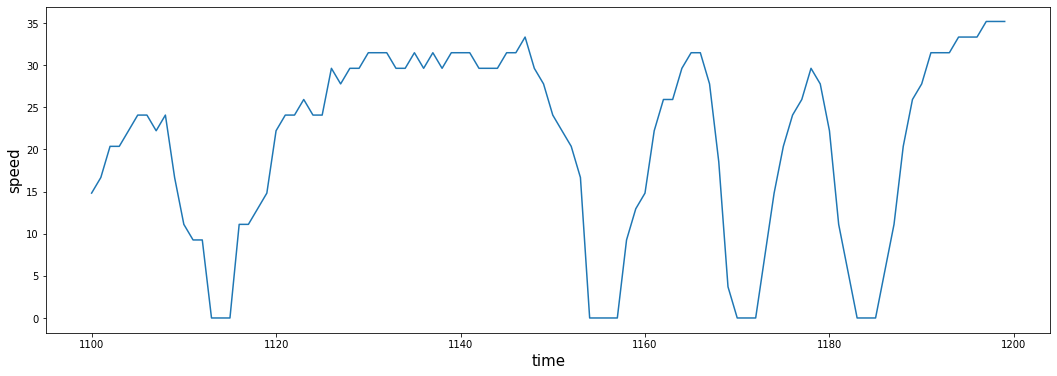

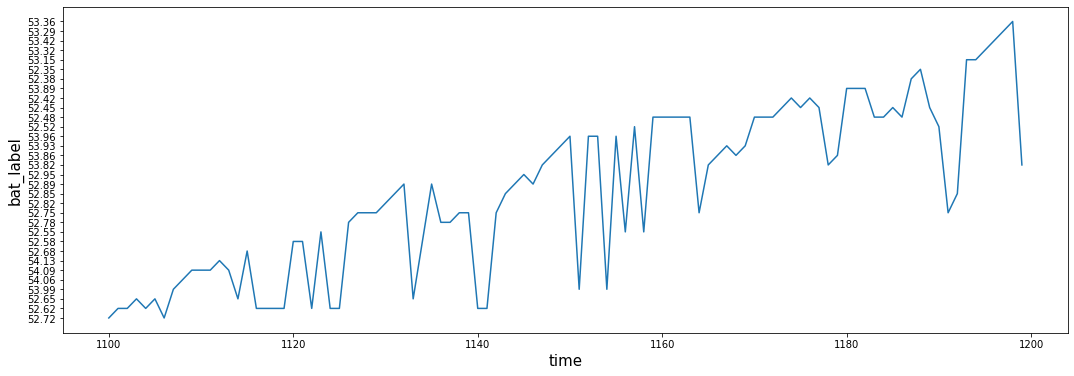

In [29]:
#import matplotlib.pyplot as plt
#%matplotlib inline

plt.figure(figsize = (18,6))
plt.plot(df["speed"][1100:1200])
plt.xlabel('time',fontsize=15)
plt.ylabel('speed',fontsize=15)
plt.show()

plt.figure(figsize = (18,6))
plt.plot(df["main_bat"][1100:1200])
plt.xlabel('time',fontsize=15)
plt.ylabel('bat_label',fontsize=15)
plt.show()

In [30]:
df[1100:1200]

main_bat              moment_time  speed  altitude  ride_id
1100    52.72  Mar 24, 2021 @ 20:15:51  14.82     895.2  77139.0
1101    52.62  Mar 24, 2021 @ 20:15:52  16.67     895.1  77139.0
1102    52.62  Mar 24, 2021 @ 20:15:53  20.37     894.6  77139.0
1103    52.65  Mar 24, 2021 @ 20:15:54  20.37     894.5  77139.0
1104    52.62  Mar 24, 2021 @ 20:15:55  22.22     894.4  77139.0
...       ...                      ...    ...       ...      ...
1195    53.32  Mar 24, 2021 @ 20:17:45  33.34     882.3  77139.0
1196    53.42  Mar 24, 2021 @ 20:17:46  33.34     882.4  77139.0
1197    53.29  Mar 24, 2021 @ 20:17:47  35.19     882.7  77139.0
1198    53.36  Mar 24, 2021 @ 20:17:48  35.19     883.0  77139.0
1199    53.82  Mar 24, 2021 @ 20:17:49  35.19     883.0  77139.0

[100 rows x 5 columns]

In [31]:
#df = df.fillna(0)
#df

In [32]:
single_len = len(group_single)
print(single_len)
len(group_single)

327


327

## Change the 'index' in group[index] below to visualise and print group values

In [33]:
group_debug_single[5]

array([[46.68000000000002, 'Mar 15, 2021 @ 11:26:16', 5.56, 0.0, 76843.0],
       [46.660000000000025, 'Mar 15, 2021 @ 11:26:17', 7.41,
        -0.6999999999999318, 76843.0],
       [46.660000000000025, 'Mar 15, 2021 @ 11:26:18', 7.41, -1.0,
        76843.0],
       [46.68000000000003, 'Mar 15, 2021 @ 11:26:19', 9.26,
        -1.1000000000000227, 76843.0],
       [46.69500000000002, 'Mar 15, 2021 @ 11:26:20', 11.11,
        -1.6999999999999318, 76843.0],
       [46.71000000000002, 'Mar 15, 2021 @ 11:26:21', 14.82, -2.0,
        76843.0],
       [47.43000000000002, 'Mar 15, 2021 @ 11:26:22', 16.67,
        -2.199999999999932, 76843.0],
       [48.18500000000002, 'Mar 15, 2021 @ 11:26:23', 16.67,
        -2.199999999999932, 76843.0],
       [47.43000000000002, 'Mar 15, 2021 @ 11:26:24', 20.37,
        -2.6000000000000227, 76843.0],
       [46.660000000000025, 'Mar 15, 2021 @ 11:26:25', 22.22,
        -2.7999999999999545, 76843.0],
       [46.68000000000003, 'Mar 15, 2021 @ 11:26:26', 22.

In [34]:
group_single[5]

array([[46.68000000000002, 5.56, 0.0],
       [46.660000000000025, 7.41, -0.6999999999999318],
       [46.660000000000025, 7.41, -1.0],
       [46.68000000000003, 9.26, -1.1000000000000227],
       [46.69500000000002, 11.11, -1.6999999999999318],
       [46.71000000000002, 14.82, -2.0],
       [47.43000000000002, 16.67, -2.199999999999932],
       [48.18500000000002, 16.67, -2.199999999999932],
       [47.43000000000002, 20.37, -2.6000000000000227],
       [46.660000000000025, 22.22, -2.7999999999999545],
       [46.68000000000003, 22.22, -2.7999999999999545],
       [46.78000000000003, 24.08, -2.0],
       [46.93000000000002, 24.08, -1.6000000000000227],
       [47.58500000000002, 25.93, 0.20000000000004547],
       [48.190000000000026, 25.93, 2.300000000000068],
       [48.20500000000003, 25.93, 3.1000000000000227],
       [47.87000000000003, 24.08, 2.800000000000068]], dtype=object)

In [35]:
len(group_single)

327

In [36]:
#for idx, single_chunks in enumerate(group_single):
    #print(single_chunks)
    #group_check_debug = group_debug_single[idx]
    #group_check = single_chunks
    #print(group_debug[16])
    #plt.figure(figsize = (12,4))
    #plt.plot(group_check)
    #plt.xlabel('time',fontsize=15)
    #plt.ylabel('speed',fontsize=15)
    #plt.show()
    #print(group_check)
    

In [37]:
os.chdir("../doublesA")
group_double = list()
group_debug_double = list()

In [38]:
path = os.getcwd()
files = os.listdir(path)
files_csv = [f for f in files if f[-3:] == 'csv']
files_csv

['77089_battery_load_analysis_data (1).csv',
 '77067_battery_load_analysis_data.csv',
 '77131_battery_load_analysis_data.csv',
 '76713_battery_load_analysis_data.csv',
 '76974_battery_load_analysis_data.csv',
 '76935_battery_load_analysis_data.csv',
 '76934_battery_load_analysis_data.csv',
 '76733_battery_load_analysis_data.csv',
 '77129_battery_load_analysis_data (1).csv',
 '77160_battery_load_analysis_data.csv',
 '76975_battery_load_analysis_data.csv',
 '77183_battery_load_analysis_data.csv',
 '77186_battery_load_analysis_data.csv',
 '77007_battery_load_analysis_data.csv',
 '77072_battery_load_analysis_data.csv',
 '76955_battery_load_analysis_data.csv',
 '77161_battery_load_analysis_data.csv',
 '76956_battery_load_analysis_data.csv',
 '77006_battery_load_analysis_data.csv']

In [39]:
iterfiles = iter(files_csv)
df = pd.read_csv(files_csv[0], usecols=["moment_time", "ride_id", "main_bat", "speed", "altitude"])

In [40]:
df

main_bat              moment_time   speed  altitude  ride_id
0      start_main_bat                      NaN     NaN       NaN      NaN
1        end_main_bat                      NaN     NaN       NaN      NaN
2            distance                      NaN     NaN       NaN      NaN
3               47.78  Mar 23, 2021 @ 18:38:20  255.00      -1.0  77089.0
4               47.72  Mar 23, 2021 @ 18:38:20  255.00      -1.0  77089.0
...               ...                      ...     ...       ...      ...
9998            46.31  Mar 23, 2021 @ 19:06:29   12.96     917.9  77089.0
9999            46.27  Mar 23, 2021 @ 19:06:29   12.96     917.9  77089.0
10000           46.31  Mar 23, 2021 @ 19:06:29   12.96     917.9  77089.0
10001           46.31  Mar 23, 2021 @ 19:06:29   12.96     917.9  77089.0
10002           46.31  Mar 23, 2021 @ 19:06:29   12.96     917.9  77089.0

[10003 rows x 5 columns]

In [41]:
df = df.drop([0,1,2])
df = df.reset_index()
df=df.drop('index', axis = 1)
t = df.groupby(by="moment_time")
keys = list(t.groups.keys())
df = frac_chunk_dataframe(files_csv[0], t, keys, df_structure)
mean_speed = (mean_speed + df["speed"].mean())/2
#df["altitude"] = df["altitude"].diff()
add_chunk_to_group_double(df)

###############
*******
*******
Unwanted:::: 0 77089_battery_load_analysis_data (1).csv
*******
###############


In [42]:
next(iterfiles)
for filename in iterfiles:
    print(filename)
    #print(df.head())
    df_next = pd.read_csv(filename, usecols=["moment_time", "ride_id", "main_bat", "speed", "altitude"])
    df_next = df_next.drop([0,1,2])
    df_next = df_next.reset_index()
    df_next=df_next.drop('index', axis = 1)
    
    t = df_next.groupby(by="moment_time")
    keys = list(t.groups.keys())
    df_next = frac_chunk_dataframe(filename, t, keys, df_structure)
    
    mean_speed = (mean_speed + df_next["speed"].mean())/2
    df = df.append(df_next, ignore_index = True) #Satish Added this line to see values in df
    #df_next["altitude"] = df_next["altitude"].diff()
    add_chunk_to_group_double(df_next)
    #print(len(group_double))
    #print("File:", filename)
    #print("df_next):", df_next)
print ("end")

77067_battery_load_analysis_data.csv
###############
*******
*******
Unwanted:::: 0 77067_battery_load_analysis_data.csv
*******
###############
77131_battery_load_analysis_data.csv
###############
*******
*******
Unwanted:::: 0 77131_battery_load_analysis_data.csv
*******
###############
76713_battery_load_analysis_data.csv
###############
*******
*******
Unwanted:::: 0 76713_battery_load_analysis_data.csv
*******
###############
76974_battery_load_analysis_data.csv
###############
*******
*******
Unwanted:::: 0 76974_battery_load_analysis_data.csv
*******
###############
76935_battery_load_analysis_data.csv
###############
*******
*******
Unwanted:::: 0 76935_battery_load_analysis_data.csv
*******
###############
76934_battery_load_analysis_data.csv
###############
*******
*******
Unwanted:::: 0 76934_battery_load_analysis_data.csv
*******
###############
76733_battery_load_analysis_data.csv
###############
*******
*******
Unwanted:::: 0 76733_battery_load_analysis_data.csv
*******
#

In [43]:
#mean_double_speed = df["speed"].mean()

#df["speed"] = df["speed"].rolling(window=3).mean()
#df["main_bat"] = df["main_bat"].rolling(window=5).mean()
bat_label = df["main_bat"].astype(float)
bat_label = bat_label.round()
#bat_label


In [44]:
bat_label

0         NaN
1        48.0
2        48.0
3        48.0
4        48.0
         ... 
13529    48.0
13530    48.0
13531    48.0
13532    48.0
13533    48.0
Name: main_bat, Length: 13534, dtype: float64

### Change the range in plt.plot(df["speed"][0:1000]) and plt.plot(df["main_bat"][0:1000]) to visualize values at different time index¶


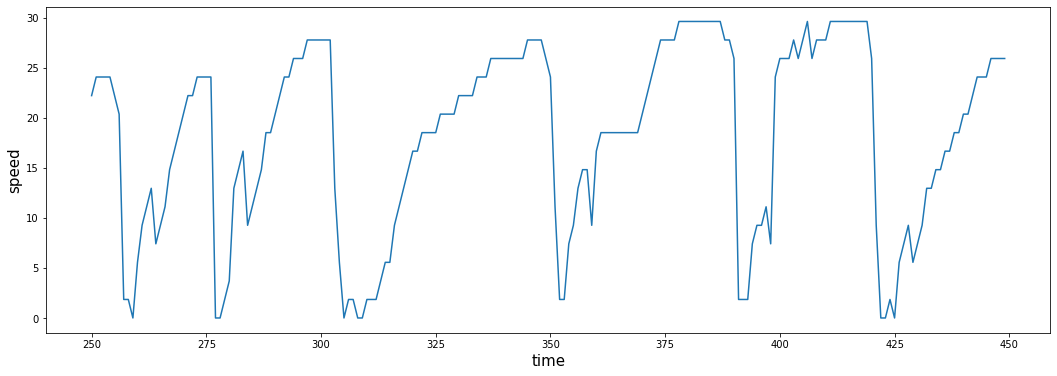

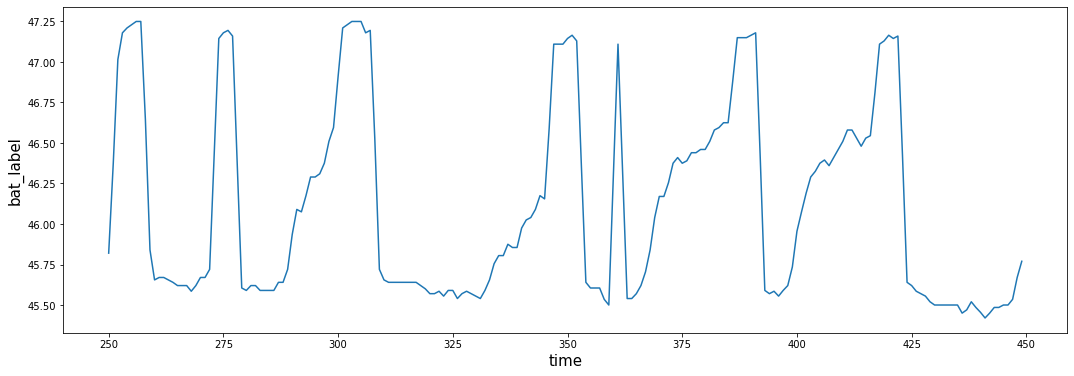

In [45]:
#import matplotlib.pyplot as plt
#%matplotlib inline

plt.figure(figsize = (18,6))
plt.plot(df["speed"][250:450])
plt.xlabel('time',fontsize=15)
plt.ylabel('speed',fontsize=15)
plt.show()

plt.figure(figsize = (18,6))
plt.plot(df["main_bat"][250:450])
plt.xlabel('time',fontsize=15)
plt.ylabel('bat_label',fontsize=15)
plt.show()

In [46]:
#df = df.fillna(0)
#df[0:50]
#df[300:350]

In [47]:
total_len = len(group_single) + len(group_double)
#double_len = total_len - single_len
double_len = len(group_double)
double_len

370

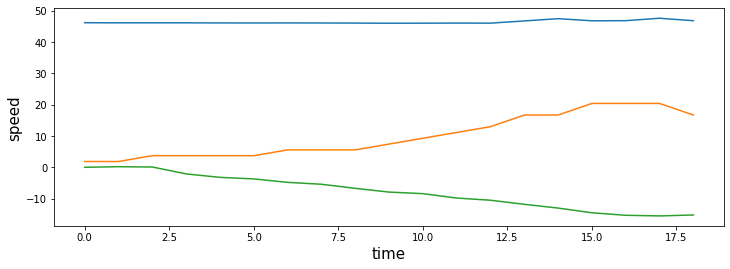

[[46.105 1.85 0.0]
 [46.07 1.85 0.20000000000004547]
 [46.07000000000001 3.7 0.10000000000002274]
 [46.07000000000001 3.7 -2.1000000000000227]
 [46.040000000000006 3.7 -3.199999999999932]
 [46.025000000000006 3.7 -3.699999999999932]
 [46.040000000000006 5.56 -4.7999999999999545]
 [46.025000000000006 5.56 -5.399999999999977]
 [45.99000000000001 5.56 -6.699999999999932]
 [45.94000000000001 7.41 -7.899999999999977]
 [45.96000000000001 9.26 -8.399999999999977]
 [45.99000000000001 11.11 -9.799999999999955]
 [45.97000000000001 12.96 -10.5]
 [46.67500000000001 16.67 -11.799999999999955]
 [47.40000000000002 16.67 -13.0]
 [46.71500000000002 20.37 -14.5]
 [46.76500000000002 20.37 -15.299999999999955]
 [47.535000000000025 20.37 -15.5]
 [46.74500000000002 16.67 -15.199999999999932]]


In [48]:
#***************************
#Change the 'index' in group[index] in the line below to visualise and print group values
#***************************
group_check = group_double[0]
plt.figure(figsize = (12,4))
plt.plot(group_check)
plt.xlabel('time',fontsize=15)
plt.ylabel('speed',fontsize=15)
plt.show()

#plt.figure(figsize = (18,6))
#plt.plot(df["main_bat"][500:2000])
#plt.xlabel('time',fontsize=15)
#plt.ylabel('bat_label',fontsize=15)
#plt.show()
print(group_check)

# FEATURE SCALING

In [49]:
#mean_speed = (mean_single_speed + mean_double_speed)/2
#for idx in range(len(group)):
#    for ids in range(len(group[idx])):
#        group[idx][ids][0] = float(group[idx][ids][0])/48.0
#        group[idx][ids][1] = float(group[idx][ids][1])/mean_speed

In [50]:
#scaler = StandardScaler()
#scaler = scaler.fit(train[])
#train = scaler.transform(train)
#test = scaler.transform(test)

# CREATING OUTPUT FILE

In [51]:
target_single = pd.DataFrame(0, index=np.arange(single_len), columns=["label"])
#target_single

In [52]:
target_double = pd.DataFrame(1, index=np.arange(double_len), columns=["label"])
#target_double

In [53]:
target = target_single.append(target_double, ignore_index = True)
#target

# PADDING THINGS PROCEED

In [54]:
#group

In [55]:
len_group = []
for one_group in group_single:
    len_group.append(len(one_group))
pd.Series(len_group).describe()

count    327.000000
mean      13.119266
std        3.969341
min        6.000000
25%       10.000000
50%       13.000000
75%       15.000000
max       31.000000
dtype: float64

In [56]:
#single_padding_len = pd.Series(len_group).describe().values[7]

In [57]:
from collections import Counter


In [58]:
counter = Counter(len_group)
all_values = counter.keys()
single_padding_len = max(all_values)
single_padding_len

31

In [59]:
len_group = []
for one_group in group_double:
    len_group.append(len(one_group))
pd.Series(len_group).describe()

count    370.000000
mean      14.135135
std        4.535689
min        6.000000
25%       11.000000
50%       14.000000
75%       17.000000
max       32.000000
dtype: float64

In [60]:
#doubles_padding_len = pd.Series(len_group).describe().values[7]

In [61]:
counter = Counter(len_group)
all_values = counter.keys()
doubles_padding_len = max(all_values)

In [62]:
doubles_padding_len

32

In [63]:
counter

Counter({6: 5,
         7: 17,
         8: 15,
         9: 22,
         10: 20,
         11: 39,
         12: 29,
         13: 28,
         14: 33,
         15: 31,
         16: 25,
         17: 23,
         18: 19,
         19: 21,
         20: 13,
         21: 9,
         22: 8,
         23: 1,
         24: 4,
         25: 2,
         26: 2,
         28: 2,
         29: 1,
         32: 1})

In [64]:
pad_len = max(single_padding_len, doubles_padding_len)
pad_len = pad_len

In [65]:
pad_len

32

In [66]:
sequences_single = group_single
#sequences_single

In [67]:
#Padding the sequence with the values in last row to max length
to_pad = pad_len
new_seq = []
for one_seq in sequences_single:
    len_one_seq = len(one_seq)
    last_val = one_seq[-1]
    #print(last_val)
    n = to_pad - len_one_seq
    #print(n)
   
    to_concat = np.repeat([0,0,0], n).reshape(3, n).transpose()
    new_one_seq = np.concatenate([one_seq, to_concat])
    new_seq.append(new_one_seq)
final_seq_single = np.stack(new_seq)

#truncate the sequence to length 60
from keras.preprocessing import sequence
seq_len = pad_len
final_seq_single=sequence.pad_sequences(final_seq_single, maxlen=seq_len, padding='post', dtype='float', truncating='post')

In [68]:
#final_seq_single

In [69]:
sequences_double = group_double
sequences_double

[array([[46.105, 1.85, 0.0],
        [46.07, 1.85, 0.20000000000004547],
        [46.07000000000001, 3.7, 0.10000000000002274],
        [46.07000000000001, 3.7, -2.1000000000000227],
        [46.040000000000006, 3.7, -3.199999999999932],
        [46.025000000000006, 3.7, -3.699999999999932],
        [46.040000000000006, 5.56, -4.7999999999999545],
        [46.025000000000006, 5.56, -5.399999999999977],
        [45.99000000000001, 5.56, -6.699999999999932],
        [45.94000000000001, 7.41, -7.899999999999977],
        [45.96000000000001, 9.26, -8.399999999999977],
        [45.99000000000001, 11.11, -9.799999999999955],
        [45.97000000000001, 12.96, -10.5],
        [46.67500000000001, 16.67, -11.799999999999955],
        [47.40000000000002, 16.67, -13.0],
        [46.71500000000002, 20.37, -14.5],
        [46.76500000000002, 20.37, -15.299999999999955],
        [47.535000000000025, 20.37, -15.5],
        [46.74500000000002, 16.67, -15.199999999999932]], dtype=object),
 array([[45.9

In [70]:
#Padding the sequence with the values in last row to max length
to_pad = pad_len
new_seq = []
for one_seq in sequences_double:
    len_one_seq = len(one_seq)
    last_val = one_seq[-1]
    n = to_pad - len_one_seq
    #print(n)
    to_concat = np.repeat([0,0,0], n).reshape(3, n).transpose()
    new_one_seq = np.concatenate([one_seq, to_concat])
    new_seq.append(new_one_seq)
final_seq_double = np.stack(new_seq)

#truncate the sequence to length 60
from keras.preprocessing import sequence
seq_len = pad_len
final_seq_double=sequence.pad_sequences(final_seq_double, maxlen=seq_len, padding='post', dtype='float', truncating='post')

In [71]:
#Disable plotting chunks for now. Saish
#for idx, single_chunks in enumerate(final_seq_single):
#    group_check_debug = group_debug_single[idx]
#    group_check = single_chunks
#    plt.figure(figsize = (12,4))
#    plt.plot(group_check)
#    plt.xlabel('time',fontsize=15)
#    plt.ylabel('speed',fontsize=15)
#    plt.show()
#    print(idx)
#    print(group_check_debug)

In [72]:
#Disable plotting chunks for now. Saish
#for idx, double_chunks in enumerate(final_seq_double):
#    group_check_debug = group_debug_double[idx]
#    group_check = double_chunks
#    plt.figure(figsize = (12,4))
#    plt.plot(group_check)
#    plt.xlabel('time',fontsize=15)
#    plt.ylabel('speed',fontsize=15)
#    plt.show()
#    print(group_check_debug)

In [73]:
#final_seq_single[0]

In [74]:
from keras.preprocessing import sequence
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

In [75]:
final_seq_single.shape

(327, 32, 3)

In [76]:
final_seq_double.shape

(370, 32, 3)

In [77]:
int(0.90*double_len)

333

In [78]:
validation_start = 0.60
validation_end = 0.80

In [79]:
train = np.vstack((final_seq_single[0:int(validation_start*single_len)], final_seq_double[0:int(validation_start*double_len)]))

In [80]:
validation = np.vstack((final_seq_single[int(validation_start*single_len):int(validation_end*single_len)], final_seq_double[int(validation_start*double_len):int(validation_end*double_len)]))

In [81]:
test = np.vstack((final_seq_single[int(validation_end*single_len):single_len], final_seq_double[int(validation_end*double_len):double_len]))

In [82]:
train.shape[0]

418

In [83]:
#target

In [84]:
train_target = np.vstack((target_single[0:int(validation_start*single_len)], target_double[0:int(validation_start*double_len)]))

In [85]:
validation_target = np.vstack((target_single[int(validation_start*single_len):int(validation_end*single_len)], target_double[int(validation_start*double_len):int(validation_end*double_len)]))

In [86]:
test_target = np.vstack((target_single[int(validation_end*single_len):single_len], target_double[int(validation_end*double_len):double_len]))

In [87]:
test_target.shape

(140, 1)

In [88]:
#validation_size_label = 10
#test_size_label = 5

In [89]:
#train = np.vstack((final_seq[0:single_len-validation_size_label], final_seq[single_len:total_len-validation_size_label]))

In [90]:
#validation = np.vstack((final_seq[single_len-validation_size_label:single_len-test_size_label], final_seq[total_len-validation_size_label:total_len-test_size_label]))
#test = np.vstack((final_seq[single_len-test_size_label:single_len], final_seq[total_len-test_size_label:total_len]))
#train_target = np.vstack((target[0:single_len-validation_size_label], target[single_len:total_len-validation_size_label]))
#validation_target = np.vstack((target[single_len-validation_size_label:single_len-test_size_label], target[total_len-validation_size_label:total_len-test_size_label]))
#test_target = np.vstack((target[single_len-test_size_label:single_len], target[total_len-test_size_label:total_len]))

In [91]:
#train = final_seq[0:120]
#f = final_seq[350:361]
#test = final_seq[0:50]

#train_target = target[0:350]
#validation_target = target[350:361]
#test_target = target[0:50]

In [92]:
train = np.array(train)
validation = np.array(validation)
test = np.array(test)

train_target = np.array(train_target)
#train_target = (train_target+1)/2

validation_target = np.array(validation_target)
#validation_target = (validation_target+1)/2

test_target = np.array(test_target)
#test_target = (test_target+1)/2

# Plotting padded Data

In [93]:
#***************************
#Change the 'index' in group[index] in the line below to visualise and print group values
#***************************
#group_check = train[0]
#plt.figure(figsize = (12,4))
#plt.plot(group_check)
#plt.xlabel('time',fontsize=15)
#plt.ylabel('speed',fontsize=15)
#plt.show()

#plt.figure(figsize = (18,6))
#plt.plot(df["main_bat"][500:2000])
#plt.xlabel('time',fontsize=15)
#plt.ylabel('bat_label',fontsize=15)
#plt.show()
#print(group_check)

# Standard Scaler Two

In [94]:
#scaler = StandardScaler()
#scaler = scaler.fit(train)
#train = scaler.transform(train)
#test = scaler.transform(test)

In [95]:
tf.keras.backend.clear_session()

In [96]:
from keras.layers import Dropout

In [97]:
model = tf.keras.models.Sequential([tf.keras.layers.Conv1D(filters=len(train), kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 3])])

In [98]:
#model = Sequential()
model.add(tf.keras.layers.Bidirectional(LSTM(len(train), return_sequences=True, input_shape=(seq_len,3))))
model.add(Dropout(0.2)) 
#model.add(LSTM(len(train), return_sequences=True, input_shape=(seq_len,3)))
#model.add(Dropout(0.2)) 
model.add(tf.keras.layers.Bidirectional(LSTM(len(train), input_shape=(seq_len,3))))
#model.add(LSTM(len(train), input_shape=(seq_len,3)))
model.add(Dropout(0.2)) 
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 418)         6688      
_________________________________________________________________
bidirectional (Bidirectional (None, None, 836)         2798928   
_________________________________________________________________
dropout (Dropout)            (None, None, 836)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 836)               4196720   
_________________________________________________________________
dropout_1 (Dropout)          (None, 836)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 837       
Total params: 7,003,173
Trainable params: 7,003,173
Non-trainable params: 0
______________________________________________

In [99]:
print(train.shape)
print(validation.shape)
print(test.shape)

(418, 32, 3)
(139, 32, 3)
(140, 32, 3)


In [100]:
adam = Adam(lr=0.00001)  #Note_Satish_change epochs=15
from keras.optimizers import SGD
#opt = SGD(lr=0.1)
#model.add(tf.keras.layers.Dense(8, input_shape=(seq_len,2)))
#model.add(Dropout(0.2))
chk = ModelCheckpoint('best_model.pkl', monitor='val_accuracy', save_best_only=True, mode='max', verbose=0)
model.compile(loss='mse', optimizer=adam, metrics=['accuracy'])
model.fit(train, train_target, epochs=200, batch_size=8, callbacks=[chk], validation_data=(validation,validation_target))
#model.compile(loss='mse', optimizer=adam, metrics=['accuracy'])
#model.fit(train, train_target, epochs=50, batch_size=20, callbacks=[chk], validation_data=(validation,validation_target))

Epoch 1/200
53/53 [==============================] - 10s 46ms/step - loss: 0.2500 - accuracy: 0.5314 - val_loss: 0.2479 - val_accuracy: 0.5396


INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


Epoch 2/200
53/53 [==============================] - 1s 20ms/step - loss: 0.2346 - accuracy: 0.5835 - val_loss: 0.2449 - val_accuracy: 0.5899


INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


Epoch 3/200
53/53 [==============================] - 1s 21ms/step - loss: 0.2349 - accuracy: 0.6368 - val_loss: 0.2443 - val_accuracy: 0.5683
Epoch 4/200
53/53 [==============================] - 1s 18ms/step - loss: 0.2229 - accuracy: 0.6710 - val_loss: 0.2452 - val_accuracy: 0.6115


INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


Epoch 5/200
53/53 [==============================] - 1s 20ms/step - loss: 0.2084 - accuracy: 0.7407 - val_loss: 0.2536 - val_accuracy: 0.5324
Epoch 6/200
53/53 [==============================] - 1s 18ms/step - loss: 0.2144 - accuracy: 0.6521 - val_loss: 0.2478 - val_accuracy: 0.5755
Epoch 7/200
53/53 [==============================] - 1s 18ms/step - loss: 0.2031 - accuracy: 0.7196 - val_loss: 0.2516 - val_accuracy: 0.6115
Epoch 8/200
53/53 [==============================] - 1s 18ms/step - loss: 0.1966 - accuracy: 0.7409 - val_loss: 0.2509 - val_accuracy: 0.5755
Epoch 9/200
53/53 [==============================] - 1s 18ms/step - loss: 0.1944 - accuracy: 0.7160 - val_loss: 0.2518 - val_accuracy: 0.5827
Epoch 10/200
53/53 [==============================] - 1s 18ms/step - loss: 0.1803 - accuracy: 0.7605 - val_loss: 0.2524 - val_accuracy: 0.5899
Epoch 11/200
53/53 [==============================] - 1s 18ms/step - loss: 0.2121 - accuracy: 0.6771 - val_loss: 0.2599 - val_accuracy: 0.6043
Epoc

INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


Epoch 22/200
53/53 [==============================] - 1s 21ms/step - loss: 0.1764 - accuracy: 0.7446 - val_loss: 0.2432 - val_accuracy: 0.6475
Epoch 23/200
53/53 [==============================] - 1s 18ms/step - loss: 0.1545 - accuracy: 0.7731 - val_loss: 0.2514 - val_accuracy: 0.6259
Epoch 24/200
53/53 [==============================] - 1s 18ms/step - loss: 0.1705 - accuracy: 0.7535 - val_loss: 0.2406 - val_accuracy: 0.6475
Epoch 25/200
53/53 [==============================] - 1s 18ms/step - loss: 0.1626 - accuracy: 0.7539 - val_loss: 0.2412 - val_accuracy: 0.6259
Epoch 26/200
53/53 [==============================] - 1s 18ms/step - loss: 0.1405 - accuracy: 0.8228 - val_loss: 0.2505 - val_accuracy: 0.6187
Epoch 27/200
53/53 [==============================] - 1s 18ms/step - loss: 0.1468 - accuracy: 0.8006 - val_loss: 0.2501 - val_accuracy: 0.6187
Epoch 28/200
53/53 [==============================] - 1s 18ms/step - loss: 0.1583 - accuracy: 0.7759 - val_loss: 0.2372 - val_accuracy: 0.6187

INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


Epoch 32/200
53/53 [==============================] - 1s 20ms/step - loss: 0.1616 - accuracy: 0.7573 - val_loss: 0.2430 - val_accuracy: 0.6259
Epoch 33/200
53/53 [==============================] - 1s 18ms/step - loss: 0.1309 - accuracy: 0.8271 - val_loss: 0.2437 - val_accuracy: 0.6259
Epoch 34/200
53/53 [==============================] - 1s 18ms/step - loss: 0.1532 - accuracy: 0.8181 - val_loss: 0.2404 - val_accuracy: 0.6403
Epoch 35/200
53/53 [==============================] - 1s 18ms/step - loss: 0.1395 - accuracy: 0.8141 - val_loss: 0.2369 - val_accuracy: 0.6475
Epoch 36/200
53/53 [==============================] - 1s 18ms/step - loss: 0.1472 - accuracy: 0.7903 - val_loss: 0.2359 - val_accuracy: 0.6403
Epoch 37/200
53/53 [==============================] - 1s 18ms/step - loss: 0.1534 - accuracy: 0.8116 - val_loss: 0.2481 - val_accuracy: 0.6475
Epoch 38/200
53/53 [==============================] - 1s 18ms/step - loss: 0.1624 - accuracy: 0.7555 - val_loss: 0.2339 - val_accuracy: 0.6619

INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


Epoch 39/200
53/53 [==============================] - 1s 21ms/step - loss: 0.1344 - accuracy: 0.8381 - val_loss: 0.2443 - val_accuracy: 0.6691


INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


Epoch 40/200
53/53 [==============================] - 1s 21ms/step - loss: 0.1346 - accuracy: 0.8275 - val_loss: 0.2370 - val_accuracy: 0.6475
Epoch 41/200
53/53 [==============================] - 1s 18ms/step - loss: 0.1448 - accuracy: 0.8101 - val_loss: 0.2547 - val_accuracy: 0.6619
Epoch 42/200
53/53 [==============================] - 1s 18ms/step - loss: 0.1351 - accuracy: 0.8319 - val_loss: 0.2413 - val_accuracy: 0.6403
Epoch 43/200
53/53 [==============================] - 1s 19ms/step - loss: 0.1391 - accuracy: 0.8101 - val_loss: 0.2435 - val_accuracy: 0.6331
Epoch 44/200
53/53 [==============================] - 1s 18ms/step - loss: 0.1407 - accuracy: 0.7999 - val_loss: 0.2378 - val_accuracy: 0.6547
Epoch 45/200
53/53 [==============================] - 1s 19ms/step - loss: 0.1402 - accuracy: 0.8214 - val_loss: 0.2727 - val_accuracy: 0.6115
Epoch 46/200
53/53 [==============================] - 1s 18ms/step - loss: 0.1581 - accuracy: 0.7840 - val_loss: 0.2822 - val_accuracy: 0.6187

INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


Epoch 86/200
53/53 [==============================] - 1s 21ms/step - loss: 0.1188 - accuracy: 0.8213 - val_loss: 0.2517 - val_accuracy: 0.6331
Epoch 87/200
53/53 [==============================] - 1s 19ms/step - loss: 0.1079 - accuracy: 0.8482 - val_loss: 0.2509 - val_accuracy: 0.6475
Epoch 88/200
53/53 [==============================] - 1s 18ms/step - loss: 0.1172 - accuracy: 0.8261 - val_loss: 0.2521 - val_accuracy: 0.6403
Epoch 89/200
53/53 [==============================] - 1s 18ms/step - loss: 0.1204 - accuracy: 0.8508 - val_loss: 0.2666 - val_accuracy: 0.6619
Epoch 90/200
53/53 [==============================] - 1s 18ms/step - loss: 0.1262 - accuracy: 0.8506 - val_loss: 0.2880 - val_accuracy: 0.6259
Epoch 91/200
53/53 [==============================] - 1s 18ms/step - loss: 0.1361 - accuracy: 0.8043 - val_loss: 0.2591 - val_accuracy: 0.6619
Epoch 92/200
53/53 [==============================] - 1s 18ms/step - loss: 0.1309 - accuracy: 0.8309 - val_loss: 0.2843 - val_accuracy: 0.6259

In [101]:
from sklearn.metrics import accuracy_score
test_preds = model.predict_classes(test)
accuracy_score(test_target, test_preds)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.7142857142857143

In [102]:
test_preds

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
    

In [103]:
test_target

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
    